In [1]:
import lightgbm as lgb  # 模型
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
from sklearn import metrics  # 混淆句子
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split  # 分层五折验证包、寻找最优参函数、切分数据
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix  # 准确率、roc计算、auc计算、混淆矩阵
import itertools  # 处理混淆矩阵
import gc  # 处理缓存，有兴趣的可以搜搜怎么使用
import warnings  # 忽略普通警告，不打印太多东西
from sklearn.feature_selection import RFE, RFECV  # 递归消除选特征，前者是自己选优化到多少位，后者是自动cv优化到最佳
from imblearn.under_sampling import RandomUnderSampler  # 朴素随机过采样，由于是比较旧的这里不做例子
from imblearn.over_sampling import SMOTE, ADASYN  # 目前流行的过采样
# SMOTE: 对于少数类样本a, 随机选择一个最近邻的样本b, 然后从a与b的连线上随机选取一个点c作为新的少数类样本;
# ADASYN: 关注的是在那些基于K最近邻分类器被错误分类的原始样本附近生成新的少数类样本;


def over_smote_(X, y, num):
    """
    功能: 二分类过采样，以smote举例。
    why: 当正负样本比例相差过大时，一般为1：20以内。举例：如果正负样本为1：99，那么相当于告诉模型只要判断为负，则正确率就为99%，那么模型就会这么做。
    X: 数据X（df型/无label）
    y: 数据y（df型/label）
    num: 过采样的个数
    reture: 
        X_resampled: 过采样后的X
        y_resampled: 过采样后的y
    """
    ss = pd.Series(y).value_counts()
    smote = SMOTE(sampling_strategy={0:ss[0],1:ss[1]+num},random_state=2019)  # radom_state为随机值种子，1:ss[1]+表示label为1的数据增加多少个
    # adasyn = ADASYN(sampling_strategy={0:ss[0],1:ss[1]+800},random_state=2019) # 改变正样本数量参数
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("过采样个数为：", num)
    check_num_X = X_resampled.shape[0] - X.shape[0]
    check_num_y = y_resampled.shape[0] - y.shape[0]
    if (check_num_X == check_num_y) and (check_num_X == num):
        print("过采样校验：成功")
        return X_resampled, y_resampled
    else:
        print("过采样校验：失败")

In [2]:
df1 = pd.read_csv('cleaned_train1.csv', index_col =0, header = 0)
df1.head()

,LABEL,AGN_CNT_RCT_12_MON,ICO_CUR_MON_ACM_TRX_TM,NB_RCT_3_MON_LGN_TMS_AGV,AGN_AGR_LATEST_AGN_AMT,ICO_CUR_MON_ACM_TRX_AMT,PUB_TO_PRV_TRX_AMT_CUR_YEAR,MON_12_EXT_SAM_NM_TRSF_OUT_CNT,MON_12_EXT_SAM_AMT,MON_12_TRX_AMT_MAX_AMT_PCTT,...,REG_DT,OPN_TM,HLD_FGN_CCY_ACT_NBR,CAGR_YEARLY_AGV_TRX_CNT,MON_12_EXR_SAM_NET_AMT,ENCASH_CNTR_RATIO,MON_12_ACT_NET_50_UP_CNT_PTY_QTY,AGN_CUR_YEAR_WAGE_RATIO,MON_12_ACM_NET_ACT_CNT,DMD_GAP
0,0.0,2642.0,72.0,425.3,759421.45,25879985.3,660732.0,492.0,-134350571.8,2.1,...,1708.45,416.84,2.0,0.569538,134350573.8,1.0,-180.0,0.736807,3430.0,-2.009249
1,0.0,2282.0,222.0,178.7,1964626.40,14755499.8,126608.3,2.0,2.0,2.0,...,199.42,195.87,2.0,-0.043937,0.0,1.0,10.0,0.601778,-2700.0,-1.286316
2,0.0,2642.0,2.0,178.7,4599822.30,2.0,2.0,2.0,2.0,2.2,...,1135.55,1122.00,2.0,0.056218,0.0,1.0,0.0,0.736807,-320.0,0.000000
3,1.0,2642.0,102.0,22.0,759421.45,11620267.6,2.0,2.0,2.0,3.1,...,98.45,92.00,2.0,-0.077670,0.0,1.0,-10.0,0.736807,30.0,0.000000
4,1.0,2642.0,102.0,178.7,759421.45,11620267.6,2.0,2.0,2.0,2.2,...,728.13,355.87,2.0,-0.121698,0.0,1.0,0.0,0.736807,-840.0,-0.056457


In [3]:
df2 = pd.read_csv('cleaned_test1.csv', index_col = 0, header = 0)
df2.head()

,AGN_CNT_RCT_12_MON,ICO_CUR_MON_ACM_TRX_TM,NB_RCT_3_MON_LGN_TMS_AGV,AGN_AGR_LATEST_AGN_AMT,ICO_CUR_MON_ACM_TRX_AMT,PUB_TO_PRV_TRX_AMT_CUR_YEAR,MON_12_EXT_SAM_NM_TRSF_OUT_CNT,MON_12_EXT_SAM_AMT,MON_12_TRX_AMT_MAX_AMT_PCTT,CUR_YEAR_PUB_TO_PRV_TRX_PTY_CNT,...,REG_DT,OPN_TM,HLD_FGN_CCY_ACT_NBR,CAGR_YEARLY_AGV_TRX_CNT,MON_12_EXR_SAM_NET_AMT,ENCASH_CNTR_RATIO,MON_12_ACT_NET_50_UP_CNT_PTY_QTY,AGN_CUR_YEAR_WAGE_RATIO,MON_12_ACM_NET_ACT_CNT,DMD_GAP
0,4602.0,102.0,205.3,87638.20,25246672.6,6102.0,2.0,2.0,3.1,12.0,...,2865.87,2061.68,12.0,-0.113021,0.0,1.0,10.0,1.000000,-880.0,-0.126089
1,2642.0,2292.0,1442.0,759421.45,324547596.7,2.0,632.0,-1200816.4,2.3,42.0,...,2066.52,1640.39,32.0,-0.108507,1200818.4,1.0,-60.0,0.736807,-3780.0,-0.406949
2,90162.0,102.0,178.7,60669325.80,147173922.3,2.0,2.0,2.0,2.1,42.0,...,506.52,486.19,2.0,0.012132,0.0,1.0,50.0,1.000000,-740.0,-0.012881
3,3562.0,402.0,128.7,4099888.10,1825444.0,2.0,2.0,2.0,2.2,42.0,...,943.61,934.58,2.0,-0.449134,0.0,1.0,10.0,0.842087,-2570.0,-2.663800
4,412.0,12.0,58.7,9000002.00,9000002.0,2.0,2.0,2.0,2.0,42.0,...,282.00,182.32,2.0,0.019048,0.0,1.0,-10.0,1.000000,-170.0,0.000000


In [4]:
X_resampled, y_resampled = over_smote_(df1.iloc[:, 1:], df1['LABEL'], 20000)

过采样个数为： 20000
过采样校验：成功


In [131]:
train_features = ['AGN_CNT_RCT_12_MON', 
       'AGN_AGR_LATEST_AGN_AMT', 
       'PUB_TO_PRV_TRX_AMT_CUR_YEAR', 'MON_12_EXT_SAM_AMT',
       'CUR_MON_COR_DPS_MON_DAY_AVG_BAL', 
       'REG_CPT', 'REG_DT', 'OPN_TM', 
       'MON_12_ACM_NET_ACT_CNT']
X_resampled2 = X_resampled[train_features]
X_resampled2
X_pred2 = df2[train_features]
X_pred2

,AGN_CNT_RCT_12_MON,AGN_AGR_LATEST_AGN_AMT,PUB_TO_PRV_TRX_AMT_CUR_YEAR,MON_12_EXT_SAM_AMT,CUR_MON_COR_DPS_MON_DAY_AVG_BAL,REG_CPT,REG_DT,OPN_TM,MON_12_ACM_NET_ACT_CNT
0,4602.0,87638.20,6102.0,2.0,19937726.2,1.678688e+08,2865.87,2061.68,-880.0
1,2642.0,759421.45,2.0,-1200816.4,62706772.3,5.000000e+07,2066.52,1640.39,-3780.0
2,90162.0,60669325.80,2.0,2.0,7019872.5,1.000000e+08,506.52,486.19,-740.0
3,3562.0,4099888.10,2.0,2.0,635059193.8,1.000000e+09,943.61,934.58,-2570.0
4,412.0,9000002.00,2.0,2.0,2705598.7,1.000000e+07,282.00,182.32,-170.0
...,...,...,...,...,...,...,...,...,...
11995,2642.0,33541914.10,2.0,-209810998.0,142916.0,8.366700e+09,1242.65,817.16,20.0
11996,2642.0,759421.45,2.0,2.0,137154592.8,1.000000e+08,728.13,869.74,-220.0
11997,2642.0,759421.45,2.0,2.0,7161.2,5.000000e+08,997.48,202.65,-30.0
11998,2642.0,759421.45,2.0,166200002.0,14055711.4,2.500000e+08,527.81,219.42,-30.0


In [134]:
X_resampled2

,AGN_CNT_RCT_12_MON,AGN_AGR_LATEST_AGN_AMT,PUB_TO_PRV_TRX_AMT_CUR_YEAR,MON_12_EXT_SAM_AMT,CUR_MON_COR_DPS_MON_DAY_AVG_BAL,REG_CPT,REG_DT,OPN_TM,MON_12_ACM_NET_ACT_CNT
0,2642.000000,7.594214e+05,6.607320e+05,-1.343506e+08,4.400083e+06,1.200000e+09,1708.450000,416.840000,3430.000000
1,2282.000000,1.964626e+06,1.266083e+05,2.000000e+00,4.009026e+07,5.000002e+06,199.420000,195.870000,-2700.000000
2,2642.000000,4.599822e+06,2.000000e+00,2.000000e+00,1.447626e+06,1.000000e+08,1135.550000,1122.000000,-320.000000
3,2642.000000,7.594214e+05,2.000000e+00,2.000000e+00,1.231850e+07,5.000020e+05,98.450000,92.000000,30.000000
4,2642.000000,7.594214e+05,2.000000e+00,2.000000e+00,2.120476e+08,1.000000e+08,728.130000,355.870000,-840.000000
...,...,...,...,...,...,...,...,...,...
59995,297.599628,1.211496e+05,4.601538e+04,2.000000e+00,5.343307e+06,1.000000e+08,1573.873839,1505.822114,-864.523113
59996,4546.183896,1.721275e+06,1.522481e+06,-3.548538e+07,4.153997e+06,1.253478e+08,1938.993743,926.836155,-1561.390387
59997,2642.000000,7.594214e+05,1.000495e+06,2.000000e+00,5.243493e+06,3.000000e+07,661.937927,641.939476,-844.433553
59998,2642.000000,7.594214e+05,8.241645e+05,-4.619167e+05,4.522325e+06,5.000002e+06,1489.087994,1487.056047,-700.840969


In [136]:
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
import matplotlib.pyplot as plt  # 图形处理包
import gc  # 处理缓存，有兴趣的可以搜搜怎么使用
import warnings  # 忽略普通警告，不打印太多东西
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']  # 让图形可以显示中文
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns  # 画图工具包


def corr_plt(data, feats, start=0, end=20, png_savename=0):
    """
    功能: 画相关系数热力图。
    why: 大于0.75的特征只留一个，不然会造成特征冗余模型效果差，但是现实情况中，一般去掉其中一个就会导致模型效果变差，请慎用。
    data: 数据集（df型）
    feats: 特征集（list性/一般是去掉id和label），可用该方法生成 feats = [x for x in data.columns if x not in ['id','label']]
    start: 用以画相关系数特征的开始点，默认0（int型）
    end: 用以画相关系数特征的结束点，默认30，-1为最终点（int型）
    png_savename: 保存图片的名字，默认不保存（str型）
    reture:
        输出相关系数图，可返回图片
    """
    corr = data[feats[start:end]].corr()  # 获取相关系数值 
    plt.figure(figsize=(20,10))    # 画布大小
    sns.heatmap(corr, annot=True)   ### 画出热力图， annot是否在方格中置入值
    if png_savename:
        plt.savefig("%s_相关系数图.png" % png_savename)  # 保存相关系数图
    plt.show()

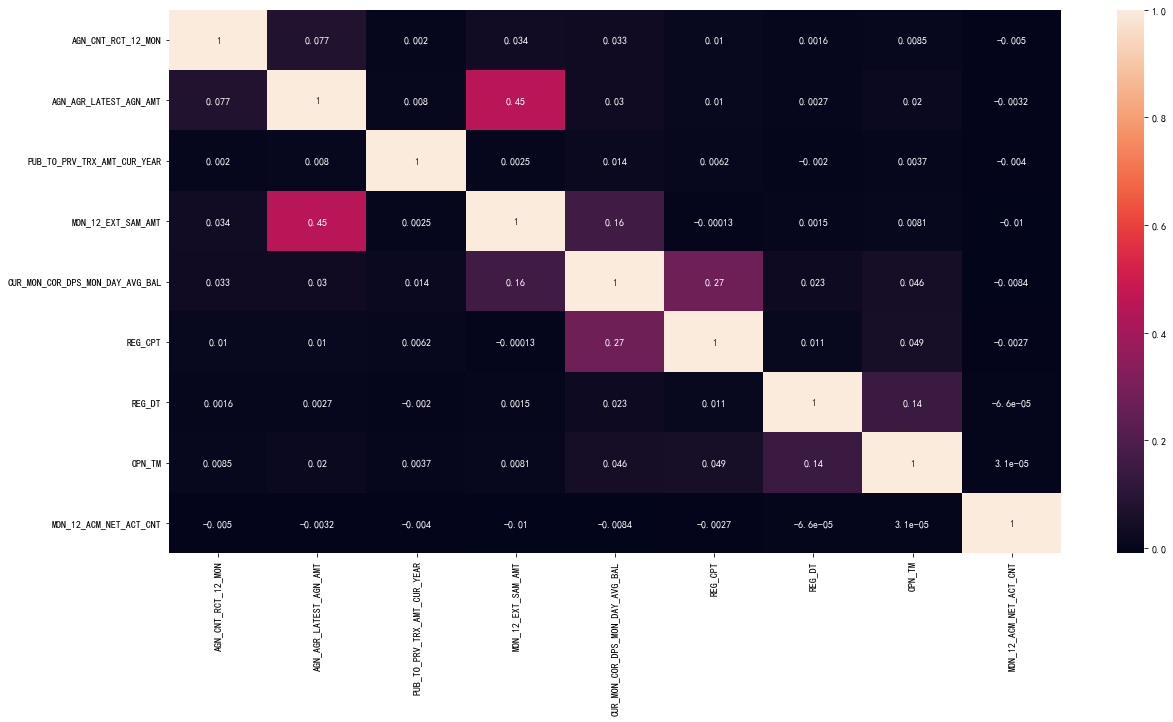

In [137]:
corr_plt(X_resampled2, list(X_resampled2.columns))

In [27]:
# test_data = pd.read_csv('cleaned_test1.csv', index_col = 0, header=0)

In [28]:
test_data.head()

,AGN_CNT_RCT_12_MON,ICO_CUR_MON_ACM_TRX_TM,NB_RCT_3_MON_LGN_TMS_AGV,AGN_AGR_LATEST_AGN_AMT,ICO_CUR_MON_ACM_TRX_AMT,PUB_TO_PRV_TRX_AMT_CUR_YEAR,MON_12_EXT_SAM_NM_TRSF_OUT_CNT,MON_12_EXT_SAM_AMT,MON_12_TRX_AMT_MAX_AMT_PCTT,CUR_YEAR_PUB_TO_PRV_TRX_PTY_CNT,...,REG_DT,OPN_TM,HLD_FGN_CCY_ACT_NBR,CAGR_YEARLY_AGV_TRX_CNT,MON_12_EXR_SAM_NET_AMT,ENCASH_CNTR_RATIO,MON_12_ACT_NET_50_UP_CNT_PTY_QTY,AGN_CUR_YEAR_WAGE_RATIO,MON_12_ACM_NET_ACT_CNT,DMD_GAP
0,4602.0,102.0,205.3,87638.20,25246672.6,6102.0,2.0,2.0,3.1,12.0,...,2865.87,2061.68,12.0,-0.113021,0.0,1.0,10.0,1.000000,-880.0,-0.126089
1,2642.0,2292.0,1442.0,759421.45,324547596.7,2.0,632.0,-1200816.4,2.3,42.0,...,2066.52,1640.39,32.0,-0.108507,1200818.4,1.0,-60.0,0.736807,-3780.0,-0.406949
2,90162.0,102.0,178.7,60669325.80,147173922.3,2.0,2.0,2.0,2.1,42.0,...,506.52,486.19,2.0,0.012132,0.0,1.0,50.0,1.000000,-740.0,-0.012881
3,3562.0,402.0,128.7,4099888.10,1825444.0,2.0,2.0,2.0,2.2,42.0,...,943.61,934.58,2.0,-0.449134,0.0,1.0,10.0,0.842087,-2570.0,-2.663800
4,412.0,12.0,58.7,9000002.00,9000002.0,2.0,2.0,2.0,2.0,42.0,...,282.00,182.32,2.0,0.019048,0.0,1.0,-10.0,1.000000,-170.0,0.000000


In [5]:
X_resampled.drop(columns='ICO_CUR_MON_ACM_TRX_TM', inplace = True)

In [7]:
df2.drop(columns='ICO_CUR_MON_ACM_TRX_TM', inplace = True)

In [15]:
import lightgbm as lgb  # 模型
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split  # 分层五折验证包、寻找最优参函数、切分数据
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix  # 准确率、roc计算、auc计算、混淆矩阵
import gc  # 处理缓存，有兴趣的可以搜搜怎么使用
import warnings  # 忽略普通警告，不打印太多东西



def just_num_leaves(X, y, start_num=10, end_num=101, step=10):
    """
    功能: 找到最优num_leaves参数，以此类推找出全部的最优参
    why: 最优参数组能让模型效果更好，一般提升在0~5%左右，如果提升超过5%，那么就要考虑特征是否选取正确，是否有过多的噪音数据。
    X: 数据X（无标签/df型）
    y: 数据y（标签/df型）
    start_num: 开始值
    end_num: 最大值
    step: 步数
    return: 最佳num_leaves
    """
    param_dic = {'num_leaves': range(start_num, end_num, step),
                # 'learning_rate': [2e-2, 2e-3, 1e-4],
                }
    gscv = GridSearchCV(estimator=lgb.LGBMClassifier(max_depth=20, min_data_in_bin=5, max_bin=200,
                                                     min_child_samples=90, n_estimators=20000,
                                                     objective='binary', boosting_type='gbdt', learning_rate=0.02,
                                                     lambda_l2=5),
                       param_grid=param_dic, scoring='roc_auc', cv=5)
    gscv.fit(X, y)
    print("best_pocrams:{0}".format(gscv.best_params_))
    print("best_score:{0}".format(gscv.best_score_))

In [138]:
X_train, X_test = X_resampled2.iloc[:35000, :], X_resampled2.iloc[35000:, :]

In [139]:
y_resampled = pd.DataFrame(y_resampled)
y_resampled

,LABEL
0,0.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
59995,1.0
59996,1.0
59997,1.0
59998,1.0


In [140]:
y_train, y_test = y_resampled.iloc[:35000, :], y_resampled.iloc[35000:, :]

In [141]:
just_num_leaves(X_resampled2, y_resampled)

[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


KeyboardInterrupt: 

In [142]:
import lightgbm as lgb  # 模型
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
from sklearn import metrics  # 混淆句子
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split  # 分层五折验证包、寻找最优参函数、切分数据
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix  # 准确率、roc计算、auc计算、混淆矩阵
import itertools  # 处理混淆矩阵
import gc  # 处理缓存，有兴趣的可以搜搜怎么使用
import warnings  # 忽略普通警告，不打印太多东西
warnings.filterwarnings('ignore')


def train_5_cross(df_pre, X,y, X_test_v1,y_test_v1, thresholds=0.45, id_1='id', csv_name=0):
    """
    功能: 五折训练并输出名单
    why: 5折一般是效果比较稳定的，用于线下做的。
    X: 训练数据X（无标签/df型）
    y: 训练数据y（标签/df型）
    X_test_v1: 预测数据X（无标签/df型）
    y_test_v1: 预测数据y（无标签/df型）
    thresholds: 阈值选择，默认0.45高精确率
    csv_name: 保存csv的名称，默认不保存
    returen:
        模型，客户名单及情况
    """
    vali_auc_num=0  # 验证集AUC
    vali_recall_num=0  # 验证集召回率
    vali_precision_num=0  # 验证集精确率
    test_auc_num=0  # 预测集AUC
    test_recall_num=0  # 预测集召回率
    test_precision_num=0  # 预测集精确率
    y_pred_input = np.zeros(len(X_test_v1))  # 相应大小的零矩阵
    print("=============开始训练================")
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)  # 分层采样, n_splits为几折
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("第 {} 次训练...".format(fold_+1))
        train_x, trai_y = X.loc[trn_idx], y.loc[trn_idx]
        vali_x, vali_y = X.loc[val_idx], y.loc[val_idx]
        
        # 以下为调过参的lgb模型
        clf = lgb.LGBMClassifier(max_depth=20, min_data_in_bin=5, max_bin=200,
                                min_child_samples=90, num_leaves=20, n_estimators=20000,
                                objective='binary', boosting_type='gbdt', learning_rate=0.002,
                                lambda_l2=5)
        clf.fit(train_x, trai_y, eval_set=[(train_x, trai_y), (vali_x, vali_y)], verbose=0,
               early_stopping_rounds=100, eval_metric='roc_auc')
        
        # 不懂的去GitHub看搜LightGBM的参数解释
        
        # ===============验证集AUC操作===================
        y_prb = clf.predict_proba(vali_x)[:,1]  # 获取预测概率
        # fpr:在实际为正的样本中，被正确判断为正的比例。tpr:在实际为负的样本中，被正确判断为负的比例。thres为阈值
        fpr, tpr, thres = roc_curve(vali_y, y_prb)
        vali_roc_auc = auc(fpr, tpr)  # 获取验证集auc
        vali_auc_num += vali_roc_auc  # 将本次auc加入总值里
        print("vali auc = {0:.4}".format(vali_roc_auc))  # 本次auc的值
        # ===============预测集AUC操作===================
        y_prb_test = clf.predict_proba(X_test_v1)[:,1]  # 获取预测概率
        fpr, tpr, thres = roc_curve(y_test_v1, y_prb_test)
        test_roc_auc = auc(fpr, tpr)
        test_auc_num += test_roc_auc
        print("test auc = {0:.4}".format(test_roc_auc))
        
        # ===============验证metric操作===================
        y_pre_proba = clf.predict_proba(vali_x.values)
        y_predictions = y_pre_proba[:, 1]>thresholds  # 取阈值多少以上的为True
        cnf_matrix = confusion_matrix(vali_y, y_predictions)  # 建立矩阵
        np.set_printoptions(precision=2)  # 控制在两位数
        vali_recall = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))  # 召回率
        vali_precision = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))  # 精确率
        print("vali_metric: ", vali_recall, vali_precision)
        vali_recall_num += float(vali_recall)  # 将本次召回率加入总值里
        vali_precision_num += float(vali_precision)  # 将本次精确率加入总值里
        # ===============预测metric操作===================
        y_pre_proba_test = clf.predict_proba(X_test_v1.values)
        y_predictions_test = y_pre_proba_test[:, 1]>thresholds  # 取阈值多少以上的为True
        cnf_matrix_test = confusion_matrix(y_test_v1, y_predictions_test)  # 建立矩阵
        np.set_printoptions(precision=2)  # 控制在两位数
        test_recall = '{0:.3f}'.format(cnf_matrix_test[1,1]/(cnf_matrix_test[1,0]+cnf_matrix_test[1,1]))  # 召回率
        test_precision = '{0:.3f}'.format(cnf_matrix_test[1,1]/(cnf_matrix_test[0,1]+cnf_matrix_test[1,1]))  # 精确率
        print("test_metric: ", test_recall, test_precision)
        test_recall_num += float(test_recall)  # 将本次召回率加入总值里
        test_precision_num += float(test_precision)  # 将本次精确率加入总值里
        y_pred_input += y_pre_proba_test[:, 1]  # 将每次的预测的结果写入数组中
        
    print("5折泛化，验证集AUC：{0:.3f}".format(vali_auc_num/5))  # 前面是做了5次相加，所以这次要除以5
    print("5折泛化，预测集AUC：{0:.3f}".format(test_auc_num/5))
    
    print("5折泛化，验证集recall：{0:.3f}".format(vali_recall_num/5))
    print("5折泛化，验证集precision：{0:.3f}".format(vali_recall_num/5))
    
    print("5折泛化，预测集recall：{0:.3f}".format(test_recall_num/5))
    print("5折泛化，预测集precision：{0:.3f}".format(test_recall_num/5))
    
    print("================开始输出名单==================")
    y_pred_input_end = y_pred_input / 5  # 前面是做了5次相加，所以这次要除以5
    y_pred_input_precision = y_pred_input_end > thresholds  # 获取高精确率的标签
    submission = pd.DataFrame({
                              "概率": y_pred_input_end,
                              "高精确": y_pred_input_precision})
    if csv_name != 0:
        submission.to_csv("%s预测名单.csv" % csv_name, index=False)  # 保存
    print("================输出名单名单==================")
    print(submission.head(5))
    return clf

In [143]:
df_pre = pd.DataFrame(columns=['id'], )
df_pre

,id


In [144]:
train_5_cross(df_pre, X_train,y_train, X_test,y_test, thresholds=0.45, id_1='id', csv_name=1)

=============开始训练================
第 1 次训练...
vali auc = 0.8634
test auc = 0.8665
vali_metric:  0.669 0.639
test_metric:  0.668 0.968
第 2 次训练...
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
vali auc = 0.8662
test auc = 0.8668
vali_metric:  0.631 0.637
test_metric:  0.664 0.968
第 3 次训练...
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
vali auc = 0.8689
test auc = 0.8666
vali_metric:  0.653 0.650
test_metric:  0.668 0.967
第 4 次训练...
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
vali auc = 0.8736
test auc = 0.8678
vali_metric:  0.665 0.630
test_metric:  0.672 0.968
第 5 次训练...
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
vali auc = 0.8619
test auc = 0.8665
vali_metric:  0.643 0.638
test_metric:  0.665 0.967
5折泛化，验证集AUC：0.867
5折泛化，预测集AUC：0.867
5折泛化，验证集recall：0.652
5折泛化，验证集precis

LGBMClassifier(lambda_l2=5, learning_rate=0.002, max_bin=200, max_depth=20,
               min_child_samples=90, min_data_in_bin=5, n_estimators=20000,
               num_leaves=20, objective='binary')

In [50]:
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
from sklearn import metrics  # 混淆矩阵
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split  # 分层五折验证包、寻找最优参函数、切分数据
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix  # 准确率、roc计算、auc计算、混淆矩阵
import itertools  # 处理混淆矩阵
import gc  # 处理缓存，有兴趣的可以搜搜怎么使用
import warnings  # 忽略普通警告，不打印太多东西


def metrics_ks(y, y_predicted):
    """
    功能: 计算模型性能指标：ks， 基于ks找到最佳threshold值
    why: ks值越高，则模型效果越好
    y: 数据y（标签/df型）
    y_predicted: 概率值， 公式为：= clf.predict_proba(X)[:, 1]
    return:
        ks值
        thres_ks值
    """
    fpr, tpr, thres = metrics.roc_curve(y, y_predicted, pos_label=1)
    ks = abs(fpr - tpr).max()  # abs:返回数字绝对值的函数
    tmp = abs(fpr - tpr)
    index_ks = np.where(tmp==ks)  # np.where: 返回符合条件的下标函数
    thres_ks = thres[index_ks]
    return ks, thres_ks

In [146]:
# submission = pd.read_csv('E:/dasein_py/Data Analysis/招商银行/test B/1预测名单.csv')
clf = lgb.LGBMClassifier(lambda_l2=5, learning_rate=0.002, max_bin=200, max_depth=20,
               min_child_samples=90, min_data_in_bin=5, n_estimators=20000,
               num_leaves=20, objective='binary')
clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=0,
               early_stopping_rounds=100, eval_metric='roc_auc')
# y_predicted = clf.predict_proba(X_test)[:, 1]
# metrics_ks(y_test, y_predicted)

LGBMClassifier(lambda_l2=5, learning_rate=0.002, max_bin=200, max_depth=20,
               min_child_samples=90, min_data_in_bin=5, n_estimators=20000,
               num_leaves=20, objective='binary')

In [147]:
# 载入五折工具及各个模型
from sklearn.model_selection import StratifiedKFold  # 数据切分、分层五折验证包
import lightgbm as lgb  # lgb模型 ,安装的方法是在anaconda promote里，直接pip install lightgbm 即可
import xgboost as xgb  # xgb模型，安装的方法是在anaconda promote里，直接pip install xgboost 即可，和lightgbm一样
# 设置skf
data_seed = 2020
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=data_seed)

In [148]:
# lgb和xgb的参数
lgb_params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.002,
    'num_leaves': 31,
    'max_depth': -1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'feature_fraction_seed': 300, ### 特征抽样的随机种子
    'bagging_seed': 3, ### 数据抽样的随机种子,取10个不同的，然后对结果求平均,todo:求出10个结果，然后求平均
    #'is_unbalance': True   #### 第一种方法：设置is_unbalance为True，表明传入的数据集是类别不平衡的
    #'scale_pos_weight': 98145/1855###负样本数量/正样本数量 -> scale_pos_weight * 正样本 == 负样本
}
xgb_params = {
    'booster': 'gbtree',  ##提升类型
    'objective': 'binary:logistic',  ###目标函数
    'eval_metric': 'auc',  ##评价函数
    'eta': 0.1,  ### 学习率 ，一般0.0几
    'max_depth': 6,  ###树最大深度
    'min_child_weight': 1,  ###最小样本二阶梯度权重, 取值是整数
    'subsample': 0.9,  ###训练数据采样 ,取值0.0~1.0之间
    'colsample_bytree': 0.9,  ###训练特征采样，取值0.0~1.0之间
    'lambda': 1,  ## l2正则，取值是整数
    'alpha': 0,   ### l1正则，取值整数
    'silent': 1   ### 取值1控制xgboost训练信息不输出
}

In [149]:
blend_train = pd.DataFrame()  # 定义df数据，以便做融合
blend_test = pd.DataFrame()  # 定义df数据，以便做融合
feats = list(X_train.columns)
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
from sklearn.metrics import roc_auc_score  # roc

In [150]:
# 训练lgb，用作第一层模型中的其中一个
test_pred_lgb = 0  # 预测结果存放对象
cv_score_lgb = []  # 存放每次auc的对象
X, y = X_resampled2, y_resampled
train_feats = np.zeros(X.shape[0])  # 整体训练的样本数量
for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print('training fold: ', idx + 1)  # 遍历的第几次
    train_x, valid_x = X.loc[train_idx], X.loc[test_idx]  # 拆分成训练集和验证集
    train_y, valid_y = y.loc[train_idx], y.loc[test_idx]  # 拆分成训练集和验证集
    dtrain = lgb.Dataset(train_x, train_y, feature_name=feats)  # 组成训练集
    dvalid = lgb.Dataset(valid_x, valid_y, feature_name=feats)  # 组成验证集
    model = lgb.train(lgb_params, dtrain, num_boost_round=2000, valid_sets=dvalid, early_stopping_rounds=50, verbose_eval=50)  # 定义lgb模型

    valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)  # 当前模型最佳参数并预测，num_iteration：选择最优的lgb
    train_feats[test_idx] = valid_pred  # 每次把验证集的结果填入，做训练的结果集，由于是5折，所以每次都是1/5的数据，把它们当作lgb训练集特征
    auc_score = roc_auc_score(valid_y, valid_pred)  # 计算auc
    print('auc score: ', auc_score)
    cv_score_lgb.append(auc_score)  # 存放验证集auc值
    test_pred_lgb += model.predict(X_pred2, num_iteration=model.best_iteration)  # 预测结果并累加，做预测的结

training fold:  1
[LightGBM] [Info] Number of positive: 24000, number of negative: 24000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.874756
[100]	valid_0's auc: 0.875711
[150]	valid_0's auc: 0.876639
[200]	valid_0's auc: 0.877612
[250]	valid_0's auc: 0.87824
[300]	valid_0's auc: 0.8786
[350]	valid_0's auc: 0.878884
[400]	valid_0's auc: 0.879421
[450]	valid_0's auc: 0.879726
[500]	valid_0's auc: 0.88003
[550]	valid_0's auc: 0.880566
[600]	valid_0's auc: 0.880882
[650]	valid_0's auc: 0.881217
[700]	valid_0's auc: 0.881643
[750]	valid_0's auc: 0.88197
[800]	valid_0's auc: 0.882345
[850]	

In [151]:
train_feats  # 训练的结果

array([0.73, 0.1 , 0.81, ..., 0.67, 0.85, 0.8 ])

In [152]:
test_pred_lgb /= 5
test_pred_lgb  # 测试的结果，由于测试的结果是5折每次的累加，所以需要除于5

array([0.16, 0.14, 0.37, ..., 0.68, 0.27, 0.71])

In [153]:
# 将训练结果和预测结果加入到blend数据集
blend_train['lgb_feat'] = train_feats
blend_test['lgb_feat'] = test_pred_lgb

In [155]:
# 训练xgb，用作第一层模型中的其中一个
test_pred_xgb = 0 # 预测结果存放对象
cv_score_xgb = []  # 存放每次auc的对象
train_feats_xgb = np.zeros(X.shape[0])  # 整体训练的样本数量
for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print('training fold: ', idx + 1) # 遍历的第几次
    train_x, valid_x = X.loc[train_idx], X.loc[test_idx]  # 拆分成训练集和验证集
    train_y, valid_y = y.loc[train_idx], y.loc[test_idx]  # 拆分成训练集和验证集
    dtrain = xgb.DMatrix(train_x, train_y, feature_names=feats)  # 组成训练集
    dvalid = xgb.DMatrix(valid_x, valid_y, feature_names=feats)  # 组成验证集
    watchlist = [(dvalid, 'eval')]
    model = xgb.train(xgb_params, dtrain, num_boost_round=2000, evals=watchlist, early_stopping_rounds=50, verbose_eval=50)  # 定义xgb模型

    valid_pred = model.predict(dvalid, ntree_limit=model.best_iteration)  # 当前模型最佳参数并预测，ntree_limit：选择最优的xgb
    train_feats_xgb[test_idx] = valid_pred  # 每次把验证集的结果填入，做训练的结果集，由于是5折，所以每次都是1/5的数据
    auc_score = roc_auc_score(valid_y, valid_pred)  # 计算auc
    print('auc score: ', auc_score)
    cv_score_xgb.append(auc_score)  # 存放验证集auc值
    dtest = xgb.DMatrix(X_pred2,feature_names=feats)  ##同时指定特征名字
    test_pred_xgb += model.predict(dtest, ntree_limit=model.best_iteration)  # 预测结果并累加，做预测的结果

training fold:  1
[11:59:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-auc:0.86038
[50]	eval-auc:0.89315
[100]	eval-auc:0.90106
[150]	eval-auc:0.90556
[200]	eval-auc:0.90732
[250]	eval-auc:0.91012
[300]	eval-auc:0.91166
[350]	eval-auc:0.91267
[400]	eval-auc:0.91375
[450]	eval-auc:0.91497
[500]	eval-auc:0.91592
[550]	eval-auc:0.91671
[600]	eval-auc:0.91781
[650]	eval-auc:0.91847
[700]	eval-auc:0.91892
[750]	eval-auc:0.91974
[800]	eval-auc:0.92029
[850]	eval-auc:0.92055
[900]	eval-auc:0.92130
[950]	eval-auc:0.92169
[1000]	eval-auc:0.92190
[1050]	eval-auc:0.92211
[1100]	eval-auc:0.92241
[1150]	eval-auc:0.92258
[1200]	eval-auc:0.92284
[1219]	eval-auc:0.9

In [156]:
train_feats_xgb  # 训练的结果

array([0.83, 0.11, 0.84, ..., 0.66, 0.94, 0.99])

In [157]:
# 将训练结果和预测结果加入到blend数据集
blend_train['xgb_feat'] = train_feats_xgb
blend_test['xgb_feat'] = test_pred_xgb

In [158]:
blend_train.head()

,lgb_feat,xgb_feat
0,0.733542,0.832418
1,0.104764,0.108267
2,0.811674,0.837787
3,0.407046,0.572145
4,0.459481,0.405450


In [159]:
blend_test.head()

,lgb_feat,xgb_feat
0,0.160672,0.110751
1,0.140335,0.021491
2,0.372588,0.443294
3,0.137228,0.034265
4,0.735225,3.921711


In [160]:
from sklearn.linear_model import LogisticRegression  # 载入lr模型，这里lr模型用作第二层模型

In [163]:
lr_model = LogisticRegression()
lr_model.fit(blend_train.values, y_resampled)

LogisticRegression()

In [164]:
lr_model.coef_  # 特征权重

array([[-0.13,  5.78]])

In [165]:
test_pred_lr = lr_model.predict_proba(blend_test.values)[:,1]  # 第二层模型预测结果

In [120]:
def get_leaderboard_score(test_df,prediction):
    """
    定义评分函数
    test_df: 测试集
    prediction: 预测结果
    reture: 输出结果分数
    """
    label = test_df['LABEL'].values  # 拿出真实样本
    assert len(prediction) == len(label)  # 断言其长度相等
    print('stacking auc score: ', roc_auc_score(label, prediction))  # 计算评分

In [166]:
np.mean(cv_score_lgb), np.std(cv_score_lgb) # lgb验证集评分

(0.8868414583333333, 0.006799913711467977)

In [122]:
blend_result = 0.5 * test_pred_lgb + 0.5 * test_pred_xgb  # 模型平均加权

In [171]:
len(test_pred_lr)
pd.DataFrame(test_pred_lr).to_csv('B9.csv')

In [93]:
get_leaderboard_score(y_test, test_pred_xgb)

stacking auc score:  0.9975566408032103


In [96]:
X_pred = df2

In [97]:
df2.shape

(12000, 26)